In [768]:
import numpy as np
import torch
from itertools import product
from scipy import stats
from functools import partial
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
from collections import defaultdict

TODO List:
- Added a convergence criterion for cases with explicit weight decay regularization.
- Added the `Groups` class which can handle imbalance sampling from groups.

In [769]:
# Linear regression
num_samples = 300     
num_features = 700
num_groups = 3

np.random.seed(42)
noise_level = 0.5
true_beta = np.random.randn( num_features, 1 ) / np.sqrt(num_features) # does not include the identifier weight.

In [770]:
def fully_structured_covariance(d):
    return np.diag( np.random.uniform(0.3, 2, size = d) )

def identity_covariance(d):
    return np.identity( d )

def partially_structured_covariace(d):
    U = np.random.randn(d,d) / np.sqrt(d)
    return np.matmul(U, U.T)

def unstructured_covariace(d):
    U = np.random.randn(d,d) / np.sqrt(d)
    return np.matmul(U, np.matmul(fully_structured_covariance(d), U.T))

class Group:


    def __init__(self, id: int, covariance_generator = lambda: identity_covariance(num_features)):

        self.id = id

        self.cov = covariance_generator()
        self.x_dist = stats.multivariate_normal( cov = self.cov )

        self.x = None
        self.y = None
    
    def copy(self):
        cov_generator = lambda: self.cov.copy()
        id = self.id
        obj = self.__class__( id, cov_generator )
        return obj
    
    # Generates X (input vars) 
    def _generate_x(self, n_samples, **kwargs):
        x = self.x_dist.rvs(size= n_samples, **kwargs)
        ID = kwargs.get("ID", False)
        if ID:
            identifier = np.repeat( self.ID , repeats=n_samples)
            x = np.column_stack( (identifier, x))
        return x

    
    @property
    def data(self):
        return self.x, self.y
    
    @data.setter
    def data(self, value):
        x, y = value # unpack
        self.x = torch.tensor(x, dtype = torch.float32, requires_grad=False)
        self.y = torch.tensor(y, dtype = torch.float32, requires_grad=False)
    

class Groups:

    WEIGHT_HANDLER = stats.beta(1,1).rvs

    def __init__(self, num_groups, cov_generator = lambda: identity_covariance(num_features)):

        self.groups = [ Group(id, cov_generator) for id in range(num_groups) ]

        weights = self.WEIGHT_HANDLER(size = num_groups)
        weights /= weights.sum()
        self.weights = weights

        self.cov = np.stack( [ group.cov * self.weights[i] for i, group in enumerate(self.groups) ], axis=2).sum(axis=2)

        self.x , self.y = None, None
          
    
    def __iter__(self):
        return self.groups.__iter__()
    
    def __getitem__(self, index):
        return self.groups[index]

    def generate(self, n_samples, beta = true_beta):

        for group in self.groups:
            # Determine number of samples for this group
            n_group = self._get_nsample(n_samples, group)

            # Create the data for that specific group
            x = group._generate_x(n_group)
            y = np.dot(x, beta) + noise_level * np.random.randn(n_group, 1)
            
            group.data = [x, y]
    
    def _get_nsample(self, n, group):
        weights = self.weights
        weights = (weights * n).astype(int)
        weights[-1] = n - weights[:-1].sum()
        return int(weights[group.id])

    
    @property
    def data(self):
        if self.x is None:
            self.x = torch.cat( [ group.x for group in self.groups ], dim = 0 )
            self.y = torch.cat( [ group.y for group in self.groups ], dim = 0 )
        return self.x, self.y

    @data.setter
    def data(self,value):
        raise AttributeError("Can't assign data to this object.")
    
    def copy(self):

        num_groups = len(self.groups)
        obj = self.__class__( num_groups )
        obj.groups = [ group.copy() for group in  self.groups ]
        obj.weights = self.weights.copy()
        obj.cov = np.stack( [ group.cov * obj.weights[i] for i, group in enumerate(obj.groups) ], axis=2).sum(axis=2)
    
        return obj

    

In [771]:

class LinearModel(torch.nn.Module):

    def __init__(self, input_dimension, **kwargs) -> None:
        super(LinearModel, self).__init__()
        # Initialize at zero. 
        self.linear = torch.nn.Linear( input_dimension, 1, bias = False, **kwargs )
        self._initialize(0.0)
    
    @classmethod
    def from_vector(cls, weights):
        weights = torch.as_tensor(weights).reshape((1,-1))
        input_dimension = weights.shape[1]
        obj = cls(input_dimension)
        obj.load_state_dict( {'linear.weight': weights} )
        return obj 
    
    @torch.no_grad()
    def _initialize(self, value):
        self.linear.weight.fill_(value)
        if self.linear.weight.grad is not None:
            self.linear.weight.grad.detach_()
            self.linear.weight.grad.zero_()
    
    # forward passes should NOT come from calling this directly!
    # i.e. model(x) instead of model.forward(x)
    def forward(self, x):
        out = self.linear(x)
        return out
    
    # by default, MSELoss divides by n, the size of sample
    def risk(self, x, y):
        loss = torch.nn.MSELoss()
        mse = loss( self(x) , y )
        return mse


def true_excess_risk( model: LinearModel, groups: Groups, beta_star = true_beta ):

    def mahalanobis_norm(a , cov):
        return float(a.T @ cov @ a)
    
    beta = model.linear.weight.data.numpy().T
    beta_diff = beta - beta_star
    assert beta_diff.shape[1] == 1
    group_risks = [mahalanobis_norm( beta_diff, group.cov ) for group in groups]

    mixture_covariance = groups.cov
    standard_risk = mahalanobis_norm(beta_diff, mixture_covariance)

    return group_risks, standard_risk
        
    
# training loop (gradient descent on the balanaced risk: lmbd * std + dro)
def optimize_GD(model, X, Y, groups, trade_regularization = 0.1, max_iter = 5000, lr = 1e-3, weight_decay = 0.0, verbose=False):
    if trade_regularization > 1:
        lmbd_adv = torch.tensor([1.0], requires_grad=False)
        lmbd_std = torch.tensor([1 / trade_regularization], requires_grad=False)
    else:
        lmbd_adv = torch.tensor([trade_regularization], requires_grad=False)
        lmbd_std = torch.tensor([1.0], requires_grad=False)

    optimizer = torch.optim.SGD( params = model.parameters(), lr = lr, weight_decay = weight_decay )

    flag = True         # for convergence criterion (objective low enough)
    iteration = 0
    prev_params = model.linear.weight.data.numpy().copy()
    prev_objective = np.inf

    while flag and iteration < max_iter:
        optimizer.zero_grad()

        standard_risk = model.risk( X, Y )
        adversarial_risk = torch.max( torch.stack( [ model.risk(group.x, group.y) for group in groups ] ) )
        objective =  standard_risk * lmbd_std + adversarial_risk * lmbd_adv

        objective.backward()
        optimizer.step()

        # Check convergence based on parameter change. 
        relative_parameter_error = np.linalg.norm( prev_params - model.linear.weight.data.numpy() ) / np.linalg.norm( model.linear.weight.data.numpy() )
        relative_objective_error = np.abs( prev_objective - objective.item() ) 
        if relative_parameter_error < 1e-6 + weight_decay:
            flag = False
        
        if iteration % 100 == 0 and verbose:
            print(f" Objective loss is {objective.item():.4f} = {lmbd_std.item():.2f} * { standard_risk.item():.4f} + {lmbd_adv.item():.2f} * {adversarial_risk.item():.4f}")
            #print(f" Relative parameter error is {relative_parameter_error}")
        iteration += 1
        
        prev_params = model.linear.weight.data.numpy().copy()
        prev_objective = objective.item()
    
    # Final round printing
    if verbose:
        print(f" Objective loss is {objective.item():.4f} = {lmbd_std.item():.2f} * { standard_risk.item():.4f} + {lmbd_adv.item():.2f} * {adversarial_risk.item():.4f} at iteration {iteration}")
        print(f" Relative parameter error is {relative_parameter_error}")
    
    if iteration == max_iter:
        print("Maximum iteration reached.")


In [772]:
# Create the trainig data
cov_generator = lambda: unstructured_covariace(num_features)
groups = Groups(num_groups, cov_generator)


groups.generate(num_samples, beta=true_beta)

X , Y = groups.data

# Test data
groups_test = groups.copy()
groups_test.generate( num_samples * 10, beta = true_beta )

X_test, Y_test = groups_test.data

# Solve the weighted regression problem using vanilla GD
max_iter = np.inf

model = LinearModel(num_features)
optimize_GD(model, X, Y, groups, trade_regularization = 1e1, weight_decay=1e-5, lr=1e-3, max_iter= max_iter, verbose=True)

 Objective loss is 1.6354 = 0.10 * 1.3262 + 1.00 * 1.5028
 Objective loss is 0.4038 = 0.10 * 0.3653 + 1.00 * 0.3673
 Objective loss is 0.2020 = 0.10 * 0.1823 + 1.00 * 0.1838
 Objective loss is 0.1230 = 0.10 * 0.1117 + 1.00 * 0.1118
 Objective loss is 0.0832 = 0.10 * 0.0751 + 1.00 * 0.0757
 Objective loss is 0.0588 = 0.10 * 0.0532 + 1.00 * 0.0535
 Objective loss is 0.0434 = 0.10 * 0.0390 + 1.00 * 0.0395
 Objective loss is 0.0324 = 0.10 * 0.0294 + 1.00 * 0.0294
 Objective loss is 0.0249 = 0.10 * 0.0225 + 1.00 * 0.0227
 Objective loss is 0.0194 = 0.10 * 0.0175 + 1.00 * 0.0177
 Objective loss is 0.0152 = 0.10 * 0.0137 + 1.00 * 0.0139
 Objective loss is 0.0121 = 0.10 * 0.0109 + 1.00 * 0.0110
 Objective loss is 0.0097 = 0.10 * 0.0087 + 1.00 * 0.0088
 Objective loss is 0.0078 = 0.10 * 0.0070 + 1.00 * 0.0071
 Objective loss is 0.0063 = 0.10 * 0.0057 + 1.00 * 0.0057
 Objective loss is 0.0052 = 0.10 * 0.0046 + 1.00 * 0.0047
 Objective loss is 0.0042 = 0.10 * 0.0038 + 1.00 * 0.0038
 Objective los

In [773]:
# OLS
ols_beta = torch.linalg.lstsq( X, Y ).solution

# Subgroups- OLS
subgroup_beta = [ torch.linalg.lstsq( group.x, group.y ).solution for group in groups ]

In [774]:
import pandas as pd
import matplotlib.pyplot as plt

betas = np.hstack( [true_beta, model.linear.weight.data.numpy().T, ols_beta.data.numpy()] + [beta.data.numpy() for beta in subgroup_beta ] )
betas = pd.DataFrame( betas, columns=["true_beta", "model", "OLS"] + [f"Group {i} OLS" for i in range(num_groups)] )

In [775]:
betas.corr()

,true_beta,model,OLS,Group 0 OLS,Group 1 OLS,Group 2 OLS
true_beta,1.000000,0.521990,0.521687,0.202569,0.333029,0.381520
model,0.521990,1.000000,0.999982,0.319887,0.631591,0.608498
OLS,0.521687,0.999982,1.000000,0.319252,0.630922,0.608203
Group 0 OLS,0.202569,0.319887,0.319252,1.000000,0.082261,0.043297
Group 1 OLS,0.333029,0.631591,0.630922,0.082261,1.000000,0.114733
Group 2 OLS,0.381520,0.608498,0.608203,0.043297,0.114733,1.000000


## Experiment 2: Adding Explicit Regularizer and Varying $\lambda$ Tradeoff Parameter
Now, we add an explicit $\ell_2$ regularization to the objective, controlled by $\eta > 0.$ This gives us the objective:
$$
\mathcal{R}_{\mathrm{trade}}(\beta; \lambda) + \eta \|\beta\|_2
= \lambda \max_{g \in \mathcal{G}} \mathbb{E}_{(X, Y) \sim \mathbb{P}_g}[(X^\top \beta - Y)^2] + \mathbb{E}_{X \sim \mathbb{P}_X}\left[ \mathbb{E} \left[ (X^\top \beta - Y)^2 \mid X \right] \right] + \eta\|\beta\|_2.
$$
Again, we first look at the effect that varying $\lambda$ has on this objective.

In [778]:
# Parameter sweep
lambdas = np.logspace(-5,2,15)
etas = np.logspace(-8, -1, 30)
#cov_gens = [ lambda: fully_structured_covariance(num_features), lambda: partially_structured_covariace(num_features), lambda: identity_covariance(num_features) ]

#params = pd.MultiIndex.from_product([lambdas, etas, cov_gens], names = ['lambda', 'eta', 'covariance_generator'])
params = pd.MultiIndex.from_product([lambdas, etas], names = ['lambda', 'eta'])

bookkeep = defaultdict(list)

for param in tqdm(params):
    # unpack
    lmbd, eta = param 

    # train tradeoff model
    model = LinearModel(num_features)
    optimize_GD(model, X , Y, groups, trade_regularization = lmbd, weight_decay = eta, max_iter= max_iter)

    # Calculate stats
    ## Training
    bookkeep['groups training risk'].append([ model.risk(group.x, group.y).item() for group in groups ])

    ## Test
    bookkeep['groups test risk'].append( [ model.risk(group.x, group.y).item() for group in groups_test ] )

    ## True standard risk
    group_risks, standard_risk = true_excess_risk(model, groups)
    bookkeep['standard excess risk'].append(standard_risk)
    bookkeep['groups excess risk'].append(group_risks)


 48%|████▊     | 215/450 [08:50<14:53,  3.80s/it]

In [764]:
df = pd.DataFrame.from_dict(dict(standard_risk = bookkeep['standard excess risk'], 
                                 adversarial_risk = list(map(max, bookkeep['groups excess risk']))
                                 )
                            )

df = pd.concat([df, pd.DataFrame(bookkeep['groups training risk']).add_prefix('training risk '), pd.DataFrame(bookkeep['groups test risk']).add_prefix('test risk ')], axis=1)
df.index = params
df.reset_index(inplace=True)

# best eta for each lambda
best = df.reset_index().groupby('lambda', as_index=False).apply( func = lambda fixed_lambda: fixed_lambda.sort_values(by = "standard_risk").iloc[0,:] )

bets_eta_ridge = best[ best['lambda'] == lambdas[0] ].loc[0,'eta']


In [765]:
mydf = df.melt(id_vars = ['standard_risk', 'adversarial_risk'],value_vars= df.columns.to_list()[2:])
mydf['phase'] = np.where(mydf.variable.str.contains('training'), 'training', 'test')
mydf['group'] = mydf.variable.str.slice(start = -1)
mydf.loc[ mydf['phase'] == 'test', 'value' ] -= noise_level ** 2

Text(0.5, 0.98, ' Regression problem with unstructured covariance matrix ')

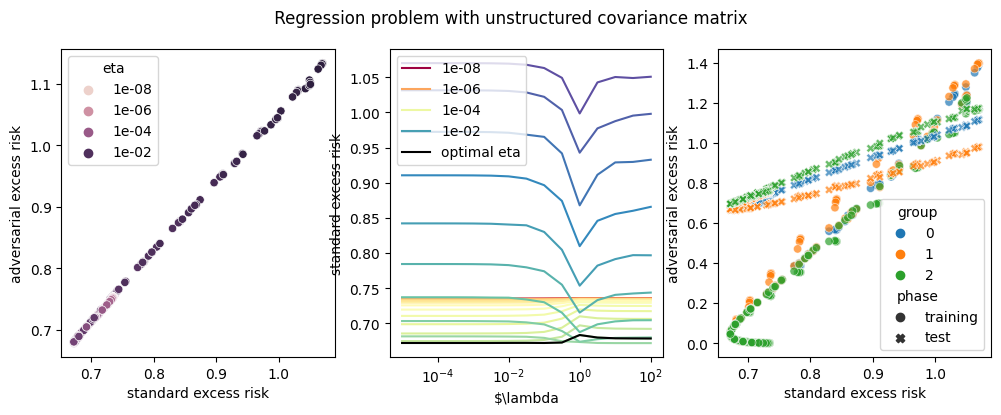

In [777]:
fig, ax = plt.subplots(1, 3, figsize=(12,4))

sns.scatterplot(x = "standard_risk", y = "adversarial_risk", hue="eta", data = df.reset_index(), hue_norm=LogNorm(vmin = min(etas), vmax = max(etas)), ax=ax[0])
ax[0].set_xlabel('standard excess risk')
ax[0].set_ylabel('adversarial excess risk')

sns.lineplot(x = 'lambda', 
             y = 'standard_risk', 
             hue = 'eta', 
             data = df, 
             hue_norm=LogNorm(), 
             palette=sns.color_palette("Spectral", as_cmap=True),
             ax = ax[1])
df[ df['eta'] == bets_eta_ridge ].plot.line(x = "lambda", y = "standard_risk", color = "k", ax = ax[1], label = "optimal eta")
ax[1].set_xscale('log')
ax[1].legend(loc="upper left")
ax[1].set_xlabel(r'$\lambda')
ax[1].set_ylabel('standard excess risk')

sns.scatterplot(x = "standard_risk", y = "value", hue = "group", style="phase", data = mydf, alpha = 0.7, ax = ax[2])
ax[2].set_xlabel('standard excess risk')
ax[2].set_ylabel('adversarial excess risk')

fig.suptitle(" Regression problem with unstructured covariance matrix ")

In [776]:
fig.savefig('dro regression--unstructured.png')